In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikes4 as spk4
import snn_models

import scipy.io as sio #allows for importing of .mat files 

# Parameters

In [2]:
#%% parameters
time_step = 1 # 1ms time resolution

lr = 0.002 # learning rate 0.005
thr = 0.6 # v threshold
tau_out = 3 # output decay time constant /// unit: ms
kappa = np.exp(-time_step/tau_out) # output decay
tau_mem = 20 # v decay time constant /// unit: ms
alpha = np.exp(-time_step/tau_mem) # v decay
beta = 0.2 # adaptation increment 
tau_a = 200 # adaptation decay time constant /// unit: ms
rho = np.exp(-time_step/(tau_a+1e-12)) # adaptation decay
t_ref = 2 # refractory period /// unit: ms

decays = np.array([lr, thr, alpha, beta, kappa, rho, t_ref]) # save as a vector

#  Neural data input preparation

In [3]:
##rootDir = ''
#fn = 'contdata95.mat'#

## conv_size = 3 # size of time history#

## load the mat file
#mat = sio.loadmat(rootDir+fn)#

## Get each variable from the mat file
## (Flipping X and Y so that X = neural data, Y = kinematics)
#x = mat['Y']
#y = mat['X'][:,0:4]#

## nsamp = x.shape[0]
## ntrain = int(np.round(nsamp*0.8)) # using 80% of data for training
## x_train = x[0:ntrain,:]
## x_test = x[ntrain+1:,:]
## y_train = y[0:ntrain,:]
## y_test = y[ntrain+1:,:]#

## Format into 10 batches
#nb_inputs, nb_hidden, nb_outputs  = 95, 100, 4
#nsamp = x.shape[0] 
#nb_batch = 10 # number of batches
#batch_size = round(nsamp/nb_batch)
#x = x[0:nb_batch*batch_size,:].astype(float)
#y = y[0:nb_batch*batch_size,:].astype(float)
#x = x.reshape((nb_batch, batch_size, nb_inputs))
#y = y.reshape((nb_batch, batch_size, nb_outputs))#

## input: 10 batches, 3141 timesteps, across 95 recording channels from premotor cortex
## output 10 batches, 3141 timesteps, 4 kinematic outputs for hand (X pos, Y pos, X vel, Y vel)
#print(x.shape)
#print(y.shape)#

## Add noise
## noise = numpy.random.choice([0, 2, 4, 6, 8], x.shape, p=[0.2, 0.2, 0.2, 0.2, 0.2])
## x = x + noise

(10, 3141, 95)
(10, 3141, 4)


# Neural data input preparation (new)

In [4]:
#x = np.load('spike_data95.npy')[0:3141000,:]
#y = np.load('interpolated_y95.npy')[0:3141000,:]#

## Format into 10 batches
#nb_inputs, nb_hidden, nb_outputs  = 95, 100, 4
#nb_batch = 10 # number of batches
#x = x.reshape((nb_batch,-1,95))
#y = y.reshape((nb_batch,-1,4))#

#print(x.shape)
#print(y.shape)
#print(np.mean(x))
#x = x / np.mean(x)
#print(np.mean(x))#

#print(np.mean(y))
#y = y / np.mean(y)
#print(np.mean(y))#

## Add noise
## noise = numpy.random.choice([0, 2, 4, 6, 8], x.shape, p=[0.2, 0.2, 0.2, 0.2, 0.2])
## x = x + noise

(10, 314100, 95)
(10, 314100, 4)
0.012533685215905092
1.0000000000000047
-1.9832492140670817
1.0


In [3]:
nb_inputs, nb_hidden, nb_outputs  = 95, 100, 4
nb_batch = 10 # number of batches
with open('spike_data95.npy', 'rb') as f:
    spike_data = np.load(f)
with open('interpolated_y95.npy', 'rb') as g:
    interpolated_y = np.load(g)

In [4]:
nb_tstep = int(spike_data.shape[0]/10)
x2 = np.zeros((nb_batch, nb_tstep, nb_inputs))
y2 = np.zeros((nb_batch, nb_tstep, 4))
for b in range(nb_batch):
    if b == 0:
        x2[b,:,:] = spike_data[0:nb_tstep,:]
        y2[b,:,:] = interpolated_y[0:nb_tstep,:]
    else:
        x2[b,:,:] = spike_data[nb_tstep*b:nb_tstep*(b+1),:]
        y2[b,:,:] = interpolated_y[nb_tstep*b:nb_tstep*(b+1),:]

y2 = y2/ np.max(np.abs(y2))

# Initialize weights

In [5]:
#%% initialize weight
weight_scale = 10*(1.0-alpha) #!!!
w1 = np.random.normal(size=(nb_inputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_inputs)) # input-->hidden
w2 = np.random.normal(size=(nb_hidden,nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->hidden
#bias = np.random.normal(size=(nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) # output bias
bias = np.zeros(nb_outputs) # output bias
B = np.random.normal(size=(nb_outputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) #!!! random e-prop

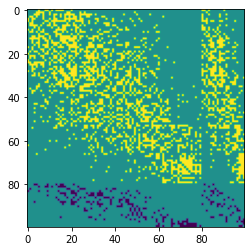

In [6]:
#%% recurrent weights (choose only one)
############### (1) random network ###############
# wr = np.random.normal(size=(nb_hidden,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->output
# np.fill_diagonal(wr,0) # no self connectivity

############### (2) E/I network ###############
import graph_analysis
nb_e = int(nb_hidden*0.8)
nb_i = nb_hidden - nb_e
ind_fromi = np.zeros((nb_hidden,nb_hidden),dtype=bool)
ind_fromi[nb_e:,:] = True # index of inhibitory neurons

wr, xy, cdens = graph_analysis.aij_distance2d([1000,1000], [250,150], nb_e, nb_i, np.array([[1,-1],[1,-1]]), cself=False, plot=False, randomseed=None)
wr = wr.T
wr *= 0.05 # scaling

plt.imshow(wr) # visualize initial weights

# Training (still debugging)

In [7]:
#%% compile (1st run numba is slow)
x = x2
y = y2
x_tmp = x[0:1,1:10,:].copy()
y_tmp = y[0:1,1:10,:].copy()
loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop2(w1,wr,w2,bias,B,x_tmp,y_tmp,decays)
print('compile done.')

nb_batch= 1
compile done.


In [8]:
x_tmp.shape

(1, 9, 95)

In [9]:
x_tmp, y_tmp = x[0:1,:,:].copy(),y[0:1,:,:].copy()
loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop2(w1,wr,w2,bias,B,x_tmp,y_tmp,decays)
print('compile done.')

nb_batch= 1
compile done.


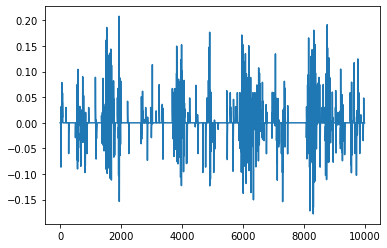

In [10]:
plt.plot(out_rec[0,1:10000,1])

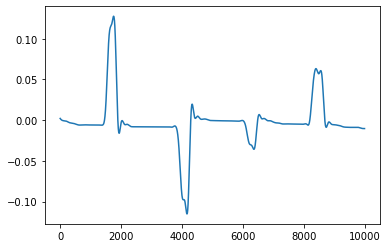

In [11]:
plt.plot(y2[0,1:10000,1])

In [12]:
#%% run train
dw1_past = np.zeros((nb_inputs,nb_hidden))
dw2_past = np.zeros((nb_hidden,nb_outputs))
dwr_past = np.zeros((nb_hidden,nb_hidden))
dbias_past = np.zeros((nb_outputs,))
loss_train, fr_train, acc_train, spktr, wrs, atr = [],[],[],[],[],[]
loss_valid, fr_valid, acc_valid = [],[],[]
n_epochs = 3

for epoch in range(n_epochs): # 100
    ######################### train #########################
    for batch_idx in range(nb_batch-2):
        
        x_train, y_train = x[batch_idx].copy(),y[batch_idx].copy()
        loss_batch, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop4(w1,wr,w2,bias,B,x_train,y_train,decays)
    
        dw1_past = 0.9*dw1_past + dw1[batch_idx] #!!! momentum=0.9
        dw2_past = 0.9*dw2_past + dw2[batch_idx] #!!! momentum=0.9
        dwr_past = 0.9*dwr_past + dwr[batch_idx] #!!! momentum=0.9
        dbias_past = 0.9*dbias_past + dbias[batch_idx] #!!! momentum=0.9
        
        w1 += dw1_past # input-->hidden update
        w2 += dw2_past # hidden-->hidden update
        wr += dwr_past # hidden-->output update
        bias += dbias_past # bias update 
        
        # w1 += np.mean(dw1,0) # these are for no-momentum update (slow learning)
        # w2 += np.mean(dw2,0)
        # wr += np.mean(dwr,0)
        # bias += np.mean(dbias,0)
        # np.fill_diagonal(wr,0) # no-self connectivity

        #!!! below 5 lines are valid only for E/I network (uncomment when using random network) 
        ind_negative = wr<0
        ind = ind_negative*(~ind_fromi) # find negative & exciatory neurons
        wr[ind] = 0. # force the negative weights to 0
        ind = (~ind_negative)*ind_fromi # find positive & inhibitory neurons
        wr[ind] = 0. # force the positive weights to 0
        
    loss_train.append(loss_batch) # save loss 
    fr_train.append(1000*z_rec.mean()) # save firing rate
    print('EPOCH %d TRAIN) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_train[epoch], fr_train[epoch]))

    ######################### validate #########################
#    x_valid,y_valid = x[8:].copy(),y[8:].copy() # 20% of data for validation
#    loss_batch, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop2(w1,wr,w2,bias,B,x_valid,y_valid,decays)
    
#    loss_valid.append(loss_batch.mean()) # save loss
#    fr_valid.append(1000*z_rec.mean()) # save firing rate
#    print('EPOCH %d VALID) loss: %0.4f, fr: %0.4f Hz' %(epoch, loss_valid[epoch], fr_valid[epoch]))
        
#    spktr.append(z_rec[0]) # save spike train /// save one batch data only to save memory
#    atr.append(a_rec[0]) # save a trace
#    wrs.append(wr.copy()) # save weights
    
    ######################### save best weights #########################
#    if loss_valid[-1] == min(loss_valid): # or you can use acc criteria instead
#        w1_save,w2_save,wr_save,bias_save = w1.copy(),w2.copy(),wr.copy(),bias.copy()
#        epoch_best = epoch
#spktr = np.stack(spktr,0)
#atr = np.stack(atr,0)
#wrs = np.stack(wrs,0)
#N = int(n_epochs/8) # epoch interval for plotting

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.StaticGetItemConstraint object at 0x00000276F7A40400>.
[1m[1mtuple index out of range[0m
[0m[1mDuring: typing of static-get-item at C:\Users\ilove\Documents\GitHub\eprop-reinforcement-learning\eprop\snn_models.py (290)[0m
Enable logging at debug level for details.
[1m
File "snn_models.py", line 290:[0m
[1mdef lif_eprop4(w1,wr,w2,bias,B,input_data,target_y,decays):
    <source elided>
    nb_steps = input_data.shape[1]
[1m    nb_inputs = input_data.shape[2]
[0m    [1m^[0m[0m


# Visualization

NameError: name 'loss_train' is not defined

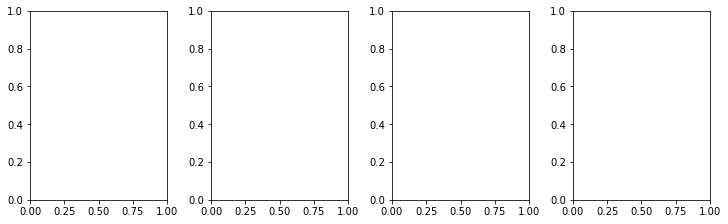

In [8]:
######################### visualization #########################
#%% loss, acc, and firing rate as a function of epoch
fig,axes = plt.subplots(1,4,figsize=(10,3),constrained_layout=True, sharex=True)
axes[0].plot(loss_train,label='train')
axes[0].plot(loss_valid,label='valid')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].plot(acc_train)
axes[1].plot(acc_valid)
axes[1].set_ylabel('Acc')
axes[1].set_xlabel('Epoch')

axes[2].plot(fr_train)
axes[2].plot(fr_valid)
axes[2].set_ylabel('firing rate (Hz)')
axes[2].set_xlabel('Epoch')

axes[3].plot(np.abs(wrs).mean(2).mean(1),'k')
axes[3].plot(np.abs(wrs[:,:nb_e,:]).mean(2).mean(1),'r',label='excitatory') #!!! uncomment when using random network
axes[3].plot(np.abs(wrs[:,nb_e:,:]).mean(2).mean(1),'b',label='inhibitory') #!!! uncomment when using random network
axes[3].set_ylabel('|w|')
axes[3].set_xlabel('Epoch')
axes[3].legend()
#%% raster plot
b = 0
fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(20,4))
axes = axes.flatten()
for j in range(8):
    spktr_tmp = spktr[N*j]
    spk4.rasterplot(spktr_tmp, ax=axes[j])
    axes[j].plot(nb_hidden/2+10*stim[-1,b],'r')
    axes[j].axis('off')
    axes[j].set_title('epoch %d' %(N*j))

fig = plt.figure(figsize=(6,3),constrained_layout=True)
spk4.rasterplot(x_batch[b], fs=0, markersize=3, t0=0, color='k')
plt.axhline(y=10,linestyle=':',c='k')
plt.axhline(y=20,linestyle=':',c='k')
plt.axhline(y=30,linestyle=':',c='k')
plt.xlabel('Time (ms)')
plt.ylabel('neuron index')
plt.savefig('raster.png')
#%% weight matrix plot
fig,axes = plt.subplots(2,4,constrained_layout=True,figsize=(10,5))
axes = axes.flatten()
cmax = 2*np.std(np.abs(wrs))
for j in range(8):
    im = axes[j].imshow(wrs[N*j], vmin=-cmax, vmax=cmax, cmap='jet')
    axes[j].set_title('epoch %d' %(N*j))
plt.colorbar(im, ax=axes[-1])
plt.savefig('weight_matrix.png')
#%% weight distribution
fig,axes = plt.subplots(2,4,constrained_layout=True,figsize=(10,5),sharex=True,sharey=True)
axes = axes.flatten()
wmax = 3*np.std(wrs)
for j in range(8):
    axes[j].hist(wrs[N*j].flatten(),bins=np.linspace(-wmax, wmax, 30),color='gray')
    axes[j].axvline(x=0,c='k',linestyle=':')
plt.savefig('weight_dist.png')
#%% save weights
import pickle
fname = r'weight_lr_v2.pkl'
file = open(fname, "wb")
dict_data = {'w1':w1_save, 'w2':w2_save, 'wr':wr_save, 'bias':bias_save}
pickle.dump(dict_data, file)
file.close()
#%% example trace and raster
b = 0
fig,axes = plt.subplots(3,1,figsize=(6,5),constrained_layout=True, sharex=True)
spk4.rasterplot(x_batch[b], fs=0, markersize=3, t0=0, color='k', nrn0=0, ax=axes[0])
axes[0].axhline(y=10,linestyle=':',c='k')
axes[0].axhline(y=20,linestyle=':',c='k')
axes[0].axhline(y=30,linestyle=':',c='k')
axes[0].set_title('input layer')
axes[0].set_ylabel('neuron index')

spk4.rasterplot(spktr[epoch_best], ax=axes[1])
axes[1].set_title('recurrent layer')
axes[1].set_ylabel('neuron index')

# axes[0].set_title('pred: %d vs. target: %d' %(np.argmax(pi[b]), y[b,-1]))
axes[2].plot(atr[epoch_best,:,:8])
axes[2].set_title('a trace')
axes[2].set_ylabel('self-inhibition (a.u.)')
axes[2].set_xlabel('Time (ms)')

plt.savefig('trace_raster.png')